# LSTM Prediction Practice

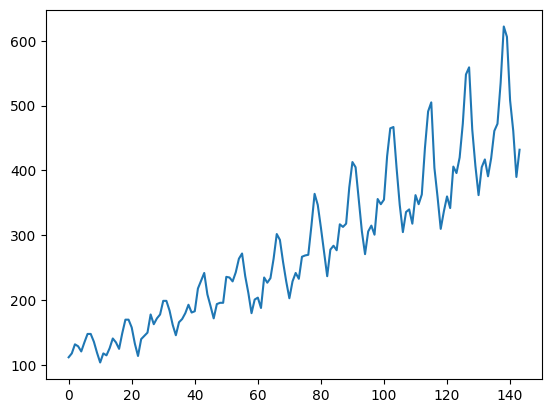

In [6]:
import os
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("airline_passengers.csv")
timeseries = df[["Passengers"]].values.astype("float32")

plt.plot(timeseries)
plt.show()

In [7]:
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [8]:
import torch


def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset

    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i : i + lookback]
        target = dataset[i + 1 : i + lookback + 1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [17]:
lookback = 20
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([76, 20, 1]) torch.Size([76, 20, 1])
torch.Size([28, 20, 1]) torch.Size([28, 20, 1])


In [18]:
import torch.nn as nn


class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1, hidden_size=50, num_layers=1, batch_first=True
        )
        self.linear = nn.Linear(50, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [19]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(
    data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8
)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 220.1120, test RMSE 417.4916
Epoch 100: train RMSE 177.5175, test RMSE 373.6007
Epoch 200: train RMSE 143.7980, test RMSE 337.9931
Epoch 300: train RMSE 114.1819, test RMSE 305.3396
Epoch 400: train RMSE 90.2474, test RMSE 276.5663
Epoch 500: train RMSE 72.9066, test RMSE 251.9405
Epoch 600: train RMSE 56.4826, test RMSE 228.3405
Epoch 700: train RMSE 44.2892, test RMSE 205.4925
Epoch 800: train RMSE 35.7141, test RMSE 186.2820
Epoch 900: train RMSE 29.5032, test RMSE 169.5127
Epoch 1000: train RMSE 25.0757, test RMSE 154.5239
Epoch 1100: train RMSE 21.2151, test RMSE 140.9464
Epoch 1200: train RMSE 18.2904, test RMSE 128.5501
Epoch 1300: train RMSE 16.0420, test RMSE 118.4626
Epoch 1400: train RMSE 14.9598, test RMSE 109.5413
Epoch 1500: train RMSE 12.8150, test RMSE 103.3070
Epoch 1600: train RMSE 11.7422, test RMSE 97.6613
Epoch 1700: train RMSE 11.1328, test RMSE 92.0472
Epoch 1800: train RMSE 10.4097, test RMSE 88.0180
Epoch 1900: train RMSE 9.7916, test RMSE 8

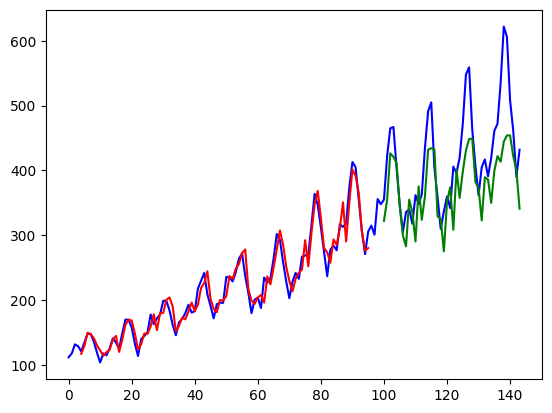

In [16]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size + lookback : len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c="b")
plt.plot(train_plot, c="r")
plt.plot(test_plot, c="g")
plt.show()